In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as dset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU available: {gpu_name}")
else:
    print("No GPU available.")

GPU available: Tesla T4


In [ ]:
image_size = 28
def show_data(sample):
  plt.imshow(sample[0].numpy().reshape((image_size, image_size)), cmap = 'gray')
  plt.title(f'y= {sample[1]}')

def plot_loss_and_accuracy(train_loss_list, accuracy_list):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 1, 1)
    plt.plot(train_loss_list, label="Training Loss", color='tab:blue')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")
    plt.twinx()
    plt.plot(accuracy_list, label="Validation Accuracy", color='tab:green')
    plt.ylabel("Accuracy")
    plt.legend(loc="upper right")
    plt.title("Training Loss and Validation Accuracy")
    plt.show()


In [ ]:
Composes = transforms.Compose([transforms.ToTensor(), transforms.Resize((image_size, image_size), antialias=True)])
train_set = dset.FashionMNIST(root='./data', train=True, transform=Composes, download = True)
validation_set = dset.FashionMNIST(root='./data', train=False, transform=Composes, download = True)
train_loader = DataLoader(train_set, batch_size=128, pin_memory=True)
validation_loader = DataLoader(validation_set, batch_size=5000)

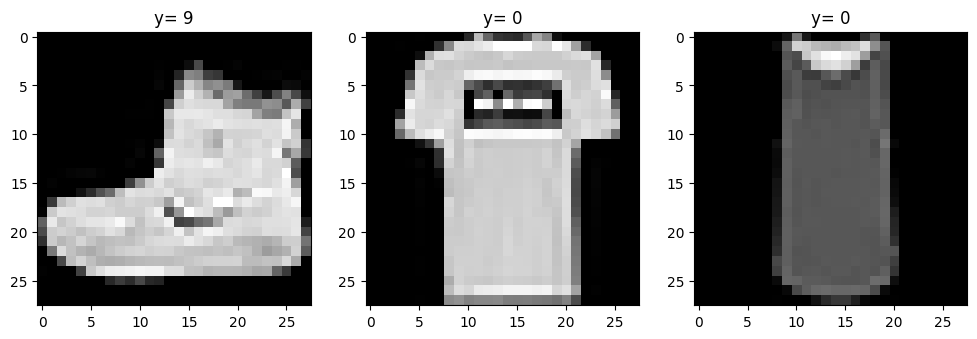

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    plt.sca(axes[i])
    show_data(train_set[i])
plt.show()

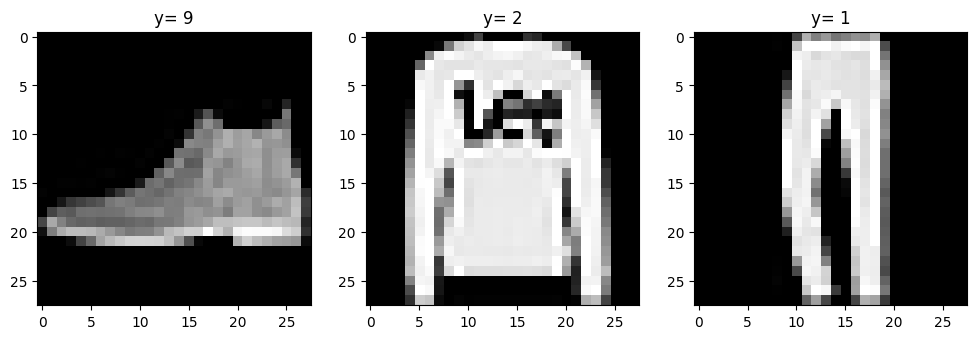

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    plt.sca(axes[i])
    show_data(validation_set[i])
plt.show()

## Output Size $= \frac{W-F + 2P}{s} + 1$

In [ ]:
class CNN(nn.Module):
  def __init__(self, out1, out2, p=0.5):
    super().__init__()
    self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = out1, kernel_size = 3, padding = 1 )
    self.batchnorm1 = nn.BatchNorm2d(out1)
    self.pool1 = nn.MaxPool2d(kernel_size = 2)
    self.relu1 = nn.ReLU()

    self.cnn2 = nn.Conv2d(in_channels = out1, out_channels = out2, kernel_size = 3, padding = 1 )
    self.batchnorm2 = nn.BatchNorm2d(out2)
    self.pool2 = nn.MaxPool2d(kernel_size = 2)
    self.relu2 = nn.ReLU()

    self.fc1 = nn.Linear(out2*7*7, 128)
    self.batchnorm3 = nn.BatchNorm1d(128)
    self.relu3 = nn.ReLU()
    self.dropout = nn.Dropout(p)

    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.cnn1(x)
    x = self.batchnorm1(x)
    x = self.relu1(x)
    x = self.pool1(x)

    x = self.cnn2(x)
    x = self.batchnorm2(x)
    x = self.relu2(x)
    x = self.pool2(x)

    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.batchnorm3(x)
    x = self.relu1(x)
    x = self.dropout(x)

    x = self.fc2(x)
    return x

In [ ]:
model = CNN(64, 32, p=0).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
epochs = 10

In [ ]:
def train_model(model, train_loader, validation_loader, optimizer, epochs):
    train_loss_list = []
    validation_loss_list = []
    accuracy_list = []
    N_test = len(validation_loader.dataset)

    for epoch in range(epochs):
        epoch_train_loss = 0.0
        for x, y in train_loader:
            optimizer.zero_grad()
            x, y = x.to("cuda"), y.to("cuda")
            yhat_train = model(x)
            loss = criterion(yhat_train, y)
            epoch_train_loss += loss
            loss.backward()
            optimizer.step()
        train_loss_list.append((epoch_train_loss/len(train_set)).item())

        correct = 0
        with torch.no_grad():
            for x_cv, y_cv in validation_loader:
                model.eval()
                x_cv, y_cv = x_cv.to("cuda"), y_cv.to("cuda")
                yhat_validation = model(x_cv)
                _, yhat_max = torch.max(yhat_validation, 1)
                correct += (yhat_max == y_cv).sum().item()
            accuracy = correct / N_test
            accuracy_list.append(accuracy)
            print(f'Epoch: {epoch} ------ last loss item: {loss} ------ accuracy: {accuracy}')

    plot_loss_and_accuracy(train_loss_list, accuracy_list)


Epoch: 0 ------ last loss item: 0.18727271258831024 ------ accuracy: 0.8957
Epoch: 1 ------ last loss item: 0.18029703199863434 ------ accuracy: 0.9027
Epoch: 2 ------ last loss item: 0.1629175990819931 ------ accuracy: 0.9064
Epoch: 3 ------ last loss item: 0.1236216127872467 ------ accuracy: 0.9073
Epoch: 4 ------ last loss item: 0.11539513617753983 ------ accuracy: 0.9042
Epoch: 5 ------ last loss item: 0.09307079762220383 ------ accuracy: 0.9075
Epoch: 6 ------ last loss item: 0.09613732248544693 ------ accuracy: 0.9021
Epoch: 7 ------ last loss item: 0.09164493530988693 ------ accuracy: 0.9058
Epoch: 8 ------ last loss item: 0.07841841131448746 ------ accuracy: 0.9072
Epoch: 9 ------ last loss item: 0.04875718429684639 ------ accuracy: 0.9068


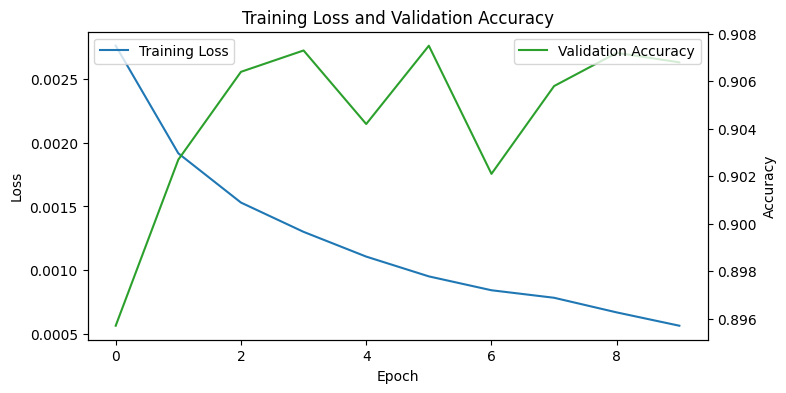

In [ ]:
train_model(model, train_loader, validation_loader, optimizer, epochs)